In [1]:
# show the matplotlib plotted graph within notebook lines.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### In case that your tqdm is not installed. Please go to the Start(Windows)->Anaconda2(64-bit)->Anaconda Prompt(py35)

### type: conda install tqdm -y

In [2]:
# import required libraries
# pandas:Data framework library for Python
# sklearn: Library to perform machine learning tasks
import os
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import scipy.stats as st
import re
import codecs
from collections import Counter
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import sklearn 
import sklearn.datasets
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import stats
nltk.download("stopwords")

C:\Anaconda\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\envs\py35\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


[nltk_data] Downloading package stopwords to C:\Windows\ServiceProfile
[nltk_data]     s\LocalService\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
# extract data
!gzip -d -k 20news-19997.tar.gz
!tar -xf 20news-19997.tar

gzip: 20news-19997.tar already exists;	not overwritten


In [3]:
# display newsgroups directories
!ls 20_newsgroups

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


## Support functions

In [4]:
def getFilesDirectory(datapath='20_newsgroups'):
    # create file directory for all files
    files = []
    for (path, dirnames, filenames) in os.walk(datapath):
        files.extend(os.path.join(path, name) for name in filenames)
    # putting file directories into pandas dataframe
    directorydf= pd.DataFrame(files)
    directorydf.columns = ['Directories']
    return directorydf

In [5]:
directorydf = getFilesDirectory()

In [6]:
# create function to help encoding the targets
def label_target (d):
    if d.find("alt.atheism") > 0 :
      return 0
    if d.find("comp.graphics") > 0:
      return 1
    if d.find("comp.os.ms-windows.misc") > 0:
      return 2
    if d.find("comp.sys.ibm.pc.hardware") > 0:
      return 3
    if d.find("comp.sys.mac.hardware") > 0:
      return 4
    if d.find("comp.windows.x") > 0:
      return 5
    if d.find("misc.forsale") > 0:
      return 6
    if d.find("rec.autos") > 0:
      return 7
    if d.find("rec.motorcycles") > 0:
      return 8
    if d.find("rec.sport.baseball") > 0:
      return 9
    if d.find("rec.sport.hockey") > 0:
      return 10
    if d.find("sci.crypt") > 0:
      return 11
    if d.find("sci.electronics") > 0:
      return 12
    if d.find("sci.med") > 0:
      return 13
    if d.find("sci.space") > 0:
      return 14
    if d.find("soc.religion.christian") > 0:
      return 15
    if d.find("talk.politics.guns") > 0:
      return 16
    if d.find("talk.politics.mideast") > 0:
      return 17
    if d.find("talk.politics.misc") > 0:
      return 18
    if d.find("talk.religion.misc") > 0:
      return 19
    return 'Other'

## Q1

### (a) 
(i) The text is processed by converting words to lowercase, filtering stopwords, removing numbers 1-9, and keeping only words with more than 2 letters.

(ii) Features are ranked by term frequency since words with higher frequency may be more important.

(iii) The top 500 most common features are selected. Larger amount of features may contain more information but too many features would take a long time to compute.

### (b)

In [7]:
def dataPreprocessor(k, fs, encode, directorydf, size=None):
    """
    INPUT
        k: int. number of features to use
        fs: string. From ['tf', 'mi']
        encode: string. From ['tf', 'boolean']
        drectorydf: Dataframe. It is given, see above support functions
        size: int. Sample size. Default should be the data size.
    OUTPUT
        data: Dataframe. preprocessed data
    
    ps: 'tf' means term frequency, 'mi' means mutual information
    """
    
    ########### your code goes here ###########
    counter = Counter()
    lemma = WordNetLemmatizer().lemmatize
    stopword = set(stopwords.words('english'))
    # Open the files and count the word frequency in each file in a loop and update the counter after finished processing a file
    for rownum, row in enumerate(directorydf.itertuples()):
        with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
            counter.update([lemma(word) for word in re.findall(r'\w+', myfile.read().lower()) if (lemma(word) not in stopword and len(lemma(word).lstrip('0123456789')) > 2)])
        if (rownum % 2000 == 0):
            print("processed %d files" % (rownum+1))
    topk = counter.most_common(k)
    np = []
    # now we had top k words, count the frequecy of these words in individual file
    if (encode == 'tf'):
        for rownum, row in enumerate(directorydf.itertuples()):
            with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
                tempCounter = Counter([lemma(word) for word in re.findall(r'\w+', myfile.read().lower())])
                topkinDoc = [tempCounter[word] for (word,wordCount) in topk]
                np.append(topkinDoc+[label_target(row.Directories)]+[row.Directories])
                if (rownum % 2000 == 0):
                    print("processed %d files" % (rownum+1))
    elif (encode == 'boolean'):    
        for rownum, row in enumerate(directorydf.itertuples()):
            with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
                tempCounter = Counter([lemma(word) for word in re.findall(r'\w+', myfile.read().lower())])
                # if the word appears in the doc, then 1, else 
                topkinDoc = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
                # create a list for top k words with encoded target and its label
                np.append(topkinDoc+[label_target(row.Directories)]+[row.Directories])
                if (rownum % 2000 == 0):
                    print("processed %d files" % (rownum+1))
                
    data = pd.DataFrame(np)
    dfName = []
    for c in topk:
        dfName.append(c[0])
    data.columns = dfName+['target','label']
    ###########         end         ###########
    return data

In [9]:
data = dataPreprocessor(k=500, fs='tf', encode='tf', directorydf=directorydf, size=None)

processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files
processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files


In [10]:
data.head()

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,understand,friend,memory,often,city,rule,pay,important,target,label
0,10,5,1,4,3,2,2,2,1,2,...,0,1,0,3,0,0,0,0,0,20_newsgroups\alt.atheism\49960
1,5,4,1,3,3,2,1,1,4,3,...,1,5,0,5,0,5,0,4,0,20_newsgroups\alt.atheism\51060
2,7,3,3,2,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51119
3,6,4,1,1,3,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51120
4,4,4,10,0,3,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51121


### (c)

In [11]:
#Confidence Interval Function
import scipy.stats
from math import sqrt
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    mu,sd = np.mean(a),np.std(a)
    z = stats.t.ppf(confidence, n)
    h=z*sd/sqrt(n)
    return mu, h

In [12]:
def randomSplitCI(data, clf, num_run, **params):
    """
    INPUT
        data: 2D numpy array. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        num_run: int. How many times you want to run for random evaluation?
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_scores: list. Results of trails
        test_scores: list. Results of trails
        train_mean: scalar. Average accuracy
        test_mean: scalar. Average accuracy
        train_ci: scalar. Confidence Interval
        test_ci: scalar. Confidence Interval
    """
    
    ########### your code goes here ###########
    num_f = len(data.columns)-2
    features_df = data.iloc[:, 0:num_f]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    if clf =='LR':
        clf = LogisticRegression(C=params['c'])
    elif clf =='SVM':
        clf = SVC(C=params['c'], probability= True)
    elif clf =='NB':
        clf = GaussianNB()
        
    train_scores = []
    test_scores = []
    for i in range(num_run):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        # train the features and target datasets and fit to a model
        clfModel = clf.fit(features_train, target_train)
        train_pred = clfModel.predict(features_train)
        test_pred = clfModel.predict(features_test)
        train_scores.append(accuracy_score(target_train, train_pred))
        test_scores.append(accuracy_score(target_test, test_pred))
    train_mean = np.mean(train_scores)
    test_mean = np.mean(test_scores)
    train_ci = mean_confidence_interval(train_scores, confidence=0.95)[1]
    test_ci = mean_confidence_interval(test_scores, confidence=0.95)[1]
    ###########         end         ###########
    return train_scores,test_scores,train_mean,test_mean,train_ci,test_ci
    

In [13]:
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = randomSplitCI(data, 'LR', 10, c=0.01)
print("Train\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trails:[0.95191826820032865, 0.95277559477030793, 0.95320425805529752, 0.95241837536614993, 0.95520468671858261, 0.95313281417446594, 0.95413302850610848, 0.95206115596199181, 0.95334714581696078, 0.95248981924698151]     
Average Accuracy: 0.9530685146817175     
Confidence Interval: 0.0005430681233338996

Test    
Result of trails:[0.93866666666666665, 0.9378333333333333, 0.93700000000000006, 0.9361666666666667, 0.9351666666666667, 0.93733333333333335, 0.93916666666666671, 0.9375, 0.9365, 0.93899999999999995]     
Average Accuracy: 0.9374333333333335     
Confidence Interval: 0.0007009224575125223


### (d)

The average shows the average accuracy score of 10 trials. The confidence interval shows the true mean accuracy falls between two values (e.g. 0.937±0.0007 for test accuracy).
They are more informative than a single trial because accuracy scores can be different due to selection of different training data.

### (e)

In [14]:
def randomSplitCM(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        cm: pandas.DataFrame. Confusion Matrix
    """
    
    ########### your code goes here ###########
    num_f = len(data.columns)-2
    features_df = data.iloc[:, 0:num_f]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    if clf =='LR':
        clf = LogisticRegression(C=params['c'])
    elif clf =='SVM':
        clf = SVC(C=params['c'], probability= True)
        clf = GridSearchCV(svc_clf, parameters, cv=5, scoring='accuracy')
    elif clf =='NB':
        clf = GaussianNB()
    
    cms = {}
    for i in range(num_run):
        features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
        # train the features and target datasets and fit to a model
        clfModel = clf.fit(features_train, target_train)
        target_pred = clfModel.predict(features_test)
        cms[i] = pd.DataFrame(metrics.confusion_matrix(target_test, target_pred))
    # Panel of all test set confusion matrices
    pl = pd.Panel(cms)
    cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
    ###########         end         ###########
    return cm

In [15]:
cm = randomSplitCM(data, 'LR', 10, c=0.01)

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  if __name__ == '__main__':


### (f)

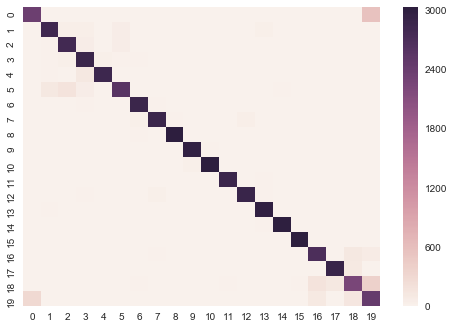

In [16]:
sns.heatmap(cm)

The plot shows that classes more easily confused are class 19 and 0, class 18 and 19, where the color is darker.

## Q2

### (a)

In [17]:
def featureSizeAC(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_mean_fs: list.
        train_ci_fs: list.
        test_mean_fs: list.
        test_ci_fs: list.
        
    """
    feature_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    
    ########### your code goes here ###########
    num_f = len(data.columns)-2
    target_df = data['target']
    target = target_df.as_matrix()
    
    if clf =='LR':
        clf = LogisticRegression(C=params['c'])
    elif clf =='SVM':
        clf = SVC(C=params['c'], probability= True)
    elif clf =='NB':
        clf = GaussianNB()

    train_mean_fs = []
    test_mean_fs = []
    train_ci_fs = []
    test_ci_fs = []
    for j in feature_precentage:
        features_df = data.iloc[:, 0:int(num_f*j)]
        features = features_df.as_matrix()
        train_scores = []
        test_scores = []
        for i in range(num_run):
            features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
            # train the features and target datasets and fit to a model
            clfModel = clf.fit(features_train, target_train)
            train_pred = clfModel.predict(features_train)
            test_pred = clfModel.predict(features_test)
            train_scores.append(accuracy_score(target_train, train_pred))
            test_scores.append(accuracy_score(target_test, test_pred))
        train_mean_fs.append(np.mean(train_scores))
        test_mean_fs.append(np.mean(test_scores))
        train_ci_fs.append(mean_confidence_interval(train_scores, confidence=0.95)[1])
        test_ci_fs.append(mean_confidence_interval(test_scores, confidence=0.95)[1])
    ###########         end         ###########
    return train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs

In [18]:
train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs = featureSizeAC(data, 'LR', 5, c=0.01)

### (b)

In [19]:
def featureSizePlot(feature_size, train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(feature_size, test_mean_fs, color=sns.xkcd_rgb["pale red"], yerr=test_ci_fs)
    train_curve=plt.errorbar(feature_size, train_mean_fs,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_fs)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Feature Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Feature Size")
    plt.show()

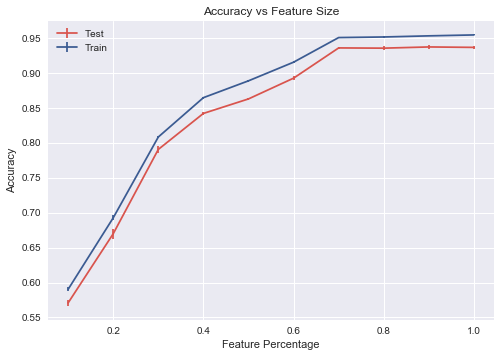

In [20]:
featureSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs )

The plot shows that accuracy increases as feature size increases, and increases are small when feature size is more than 70%.

## Q3

In [33]:
def hyperParameterAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
    
    OUTPUT
        test_mean_hp: list.  mean accuracy list of test
        test_ci_hp: list. confidence interval list of test
        train_mean_hp: list. mean accuracy list of train
        train_ci_hp: list. confidence interval list of train
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    params = np.logspace(-4, 4, num=9)
    
    ########### your code goes here ###########
    num_f = len(data.columns)-2
    features_df = data.iloc[:, 0:num_f]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    train_mean_hp = []
    test_mean_hp = []
    train_ci_hp = []
    test_ci_hp = []
    if clf =='LR':
        for j in params:
            clf = LogisticRegression(C=j)
            train_scores = []
            test_scores = []
            for i in range(num_run):
                features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
                # train the features and target datasets and fit to a model
                clfModel = clf.fit(features_train, target_train)
                train_pred = clfModel.predict(features_train)
                test_pred = clfModel.predict(features_test)
                train_scores.append(accuracy_score(target_train, train_pred))
                test_scores.append(accuracy_score(target_test, test_pred))
            train_mean_hp.append(np.mean(train_scores))
            test_mean_hp.append(np.mean(test_scores))
            train_ci_hp.append(mean_confidence_interval(train_scores, confidence=0.95)[1])
            test_ci_hp.append(mean_confidence_interval(test_scores, confidence=0.95)[1])
    elif clf == 'SVM':
        for j in params:
            clf = SVC(C=j, probability= True)
            train_scores = []
            test_scores = []
            for i in range(num_run):
                features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3)
                # train the features and target datasets and fit to a model
                clfModel = clf.fit(features_train, target_train)
                train_pred = clfModel.predict(features_train)
                test_pred = clfModel.predict(features_test)
                train_scores.append(accuracy_score(target_train, train_pred))
                test_scores.append(accuracy_score(target_test, test_pred))
            train_mean_hp.append(np.mean(train_scores))
            test_mean_hp.append(np.mean(test_scores))
            train_ci_hp.append(mean_confidence_interval(train_scores, confidence=0.95)[1])
            test_ci_hp.append(mean_confidence_interval(test_scores, confidence=0.95)[1])
    ###########         end         ###########
    return train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

In [15]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(data, 'LR', 3)

### (b)

In [34]:
def hyperParameterPlot(params, train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(params, test_mean_hp, color=sns.xkcd_rgb["pale red"], yerr=test_ci_hp)
    train_curve=plt.errorbar(params, train_mean_hp,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_hp)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Parameter')
    plt.xscale("log")
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Parameters")
    plt.show()

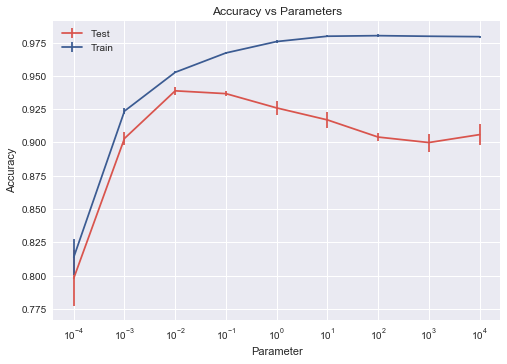

In [17]:
hyperParameterPlot(np.logspace(-4, 4, num=9),train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp )

The plot shows that accuracy for training data increases as hyperparameter becomes lager, and accuracy for testing data is largest when hyperparameter=$10^{-2}$.

## Q4

### (a)

In [22]:
def dataSizeAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        test_mean_ds: list.  mean accuracy list of test
        test_ci_ds: list. confidence interval list of test
        train_mean_ds: list. mean accuracy list of train
        train_ci_ds: list. confidence interval list of train
        
        
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    data_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    
    ########### your code goes here ###########
    num_f = len(data.columns)-2
    features_df = data.iloc[:, 0:num_f]
    features = features_df.as_matrix()
    target_df = data['target']
    target = target_df.as_matrix()
    
    if clf =='LR':
        clf = LogisticRegression(C=0.01)
    elif clf =='SVM':
        clf = SVC(C=1.0, probability= True)
    elif clf =='NB':
        clf = GaussianNB()
    
    train_mean_ds = []
    test_mean_ds = []
    train_ci_ds = []
    test_ci_ds = []
    for j in data_precentage:
        size = 0.7*j
        train_scores = []
        test_scores = []
        for i in range(num_run):
            #set training data to j percent of training data
            features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=size, test_size=0.3)
            # train the features and target datasets and fit to a model
            clfModel = clf.fit(features_train, target_train)
            train_pred = clfModel.predict(features_train)
            test_pred = clfModel.predict(features_test)
            train_scores.append(accuracy_score(target_train, train_pred))
            test_scores.append(accuracy_score(target_test, test_pred))
        train_mean_ds.append(np.mean(train_scores))
        test_mean_ds.append(np.mean(test_scores))
        train_ci_ds.append(mean_confidence_interval(train_scores, confidence=0.95)[1])
        test_ci_ds.append(mean_confidence_interval(test_scores, confidence=0.95)[1])
    ###########         end         ###########
    return train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds

In [23]:
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds = dataSizeAC(data, 'LR', 3)

### (b)

In [24]:
def dataSizePlot(datasize, train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(datasize, test_mean_ds, color=sns.xkcd_rgb["pale red"], yerr=test_ci_ds)
    train_curve=plt.errorbar(datasize, train_mean_ds,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_ds)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Data Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Data Percentage")
    plt.show()

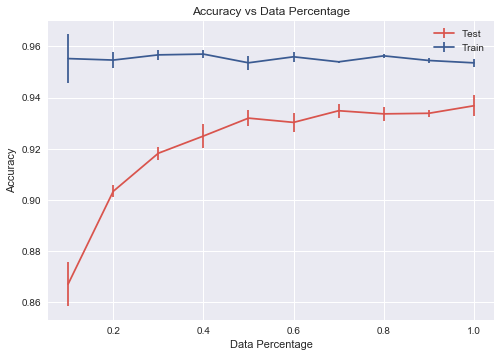

In [25]:
dataSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds)

The plot show that accuracy for testing data inceases when training data size is larger.

## Q5

### (a)

In [26]:
data1 = dataPreprocessor(k=500, fs='tf', encode='tf', directorydf=directorydf, size=None)
data2 = dataPreprocessor(k=500, fs='tf', encode='boolean', directorydf=directorydf, size=None)

processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files
processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files
processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files
processed 1 files
processed 2001 files
processed 4001 files
processed 6001 files
processed 8001 files
processed 10001 files
processed 12001 files
processed 14001 files
processed 16001 files
processed 18001 files


In [27]:
data1.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,understand,friend,memory,often,city,rule,pay,important,target,label
0,10,5,1,4,3,2,2,2,1,2,...,0,1,0,3,0,0,0,0,0,20_newsgroups\alt.atheism\49960


binary encodinng:

In [29]:
data2.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,understand,friend,memory,often,city,rule,pay,important,target,label
0,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,20_newsgroups\alt.atheism\49960


### (b)

You should be able to get this answer easily by running dataPreprocessor fuction and randomSplitCI function

In [28]:
train_scores1,test_scores1,train_mean1,test_mean1,train_ci1,test_ci1 = randomSplitCI(data1, 'LR', 10, c=0.01)
train_scores2,test_scores2,train_mean2,test_mean2,train_ci2,test_ci2 = randomSplitCI(data2, 'LR', 10, c=0.01)

In [30]:
print("TF Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean1-train_ci1, train_mean1+train_ci1)
     )
print("TF Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean1-test_ci1, test_mean1+test_ci1)
     )
print("Binary Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean2-train_ci2, train_mean2+train_ci2)
     )
print("Binary Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean2-test_ci2, test_mean2+test_ci2)
     )

TF Train    
Confidence Interval: 0.9521623286345082, 0.9533031282491096

TF Test    
Confidence Interval: 0.9363829288872169, 0.9389504044461162

Binary Train    
Confidence Interval: 0.9642572753522508, 0.9650990152814564

Binary Test    
Confidence Interval: 0.9519096879110349, 0.9541236454222983



Confidence intervals of both training and testing data shows that binary encoding method performs
better. The reason may be that for binary encoding, features are on the same scale, but for term frequency, the data can be wildly different so it does not present data for different features or different documents equally.

## Q6

### (a)

In [35]:
train_scores1,test_scores1,train_mean1,test_mean1,train_ci1,test_ci1 = randomSplitCI(data2, 'LR', 10, c=0.01)
train_scores2,test_scores2,train_mean2,test_mean2,train_ci2,test_ci2 = randomSplitCI(data2, 'NB', 10, c=0.01)

In [36]:
print("Logistic Regression Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean1-train_ci1, train_mean1+train_ci1)
     )
print("Logistic Regression\
    \nConfidence Interval: {0}, {1}\n".format(test_mean1-test_ci1, test_mean1+test_ci1)
     )
print("Naive Bayes Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean2-train_ci2, train_mean2+train_ci2)
     )
print("Naive Bayes Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean2-test_ci2, test_mean2+test_ci2)
     )

Logistic Regression Train    
Confidence Interval: 0.9634550812105811, 0.9643580215971632

Logistic Regression    
Confidence Interval: 0.9538449766584968, 0.95622169000817

Naive Bayes Train    
Confidence Interval: 0.9305058954416688, 0.9396662843111353

Naive Bayes Test    
Confidence Interval: 0.9216260747337589, 0.9301405919329079



Confidence intervals of both training and testing data shows that logistic regression performs better. The reason may ne that Naive Bayes assumes that the features are conditionally independent and it does not take intercorrelations among features into account.

## binary logistic regression to classify sci.space

## Q1 (binary)

Same as Q1 above,

(i) The text is processed by converting words to lowercase, filtering stopwords, removing numbers 1-9, and keeping only words with more than 2 letters.

(ii) Features are ranked by term frequency since words with higher frequency may be more important.

(iii) The top 500 most common features are selected. Larger amount of features may contain more information but too many features would take a long time to compute.

In [21]:
data_bi = data.copy()
data_bi.loc[data_bi.target != 14, 'target'] = 0
data_bi.loc[data_bi.target == 14, 'target'] = 1

In [27]:
data_bi.head()

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,friend,everything,memory,city,often,rule,pay,important,target,label
0,10,5,1,4,3,2,2,2,1,2,...,1,0,0,0,3,0,0,0,0,20_newsgroups\alt.atheism\49960
1,5,4,1,3,3,2,1,1,4,3,...,5,2,0,0,5,5,0,4,0,20_newsgroups\alt.atheism\51060
2,7,3,3,2,2,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51119
3,6,4,1,1,3,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51120
4,4,4,10,0,3,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,20_newsgroups\alt.atheism\51121


In [28]:
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = randomSplitCI(data_bi, 'LR', 10, c=1.0)
print("Train\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

Train    
Result of trails:[0.99985711223833673, 0.99978566835750515, 0.99985711223833673, 0.99992855611916842, 1.0, 0.99992855611916842, 0.99978566835750515, 0.99985711223833673, 0.99978566835750515, 0.99978566835750515]     
Average Accuracy: 0.9998571122383367     
Confidence Interval: 4.0948098296702085e-05

Test    
Result of trails:[0.99750000000000005, 0.997, 0.99733333333333329, 0.99716666666666665, 0.99650000000000005, 0.9976666666666667, 0.99750000000000005, 0.99733333333333329, 0.99750000000000005, 0.99833333333333329]     
Average Accuracy: 0.9973833333333333     
Confidence Interval: 0.00025649864884557717


The average shows the average accuracy score of 10 trials. The confidence interval shows the true mean accuracy falls between two values (e.g. 0.997$\pm$0.00026 for test accuracy). They are more informative than a single trial because accuracy scores can be different due to selection of different training data.

## Q2 (binary)

In [38]:
train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs = featureSizeAC(data_bi, 'LR', 10, c=1.0)

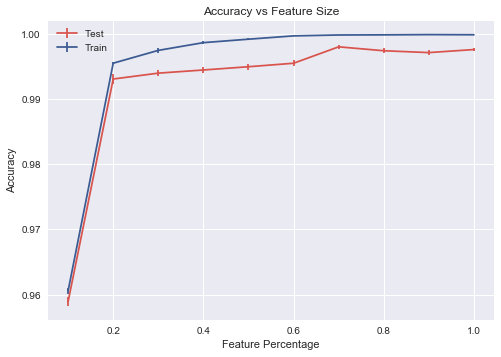

In [39]:
featureSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs )

The plot shows that accuracy increases as feature size increases, and increases are small when feature size is more than 20%.

## Q3 (binary)

In [40]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(data_bi, 'LR', 3)

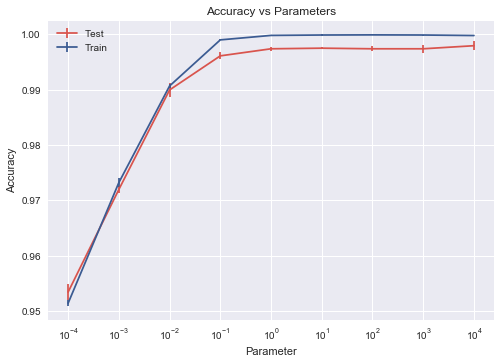

In [41]:
hyperParameterPlot(np.logspace(-4, 4, num=9),train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp )

The plot shows that accuracy for both training and testing data increases as hyperparameter becomes lager, and there is little increase when hyperparameter is larger than 1.0.

## Q4 (binary)

In [42]:
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds = dataSizeAC(data_bi, 'LR', 3)

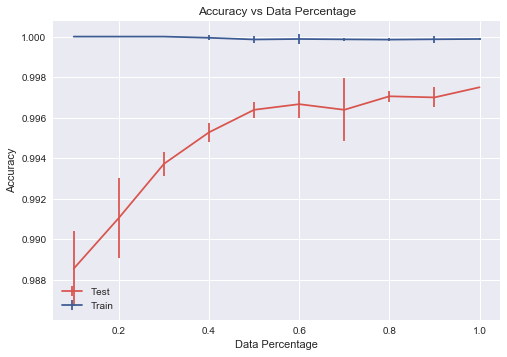

In [43]:
dataSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds)

The plot show that accuracy for testing data inceases when training data size is larger.

## Q5 (binary)

In [65]:
data_bi2 = data2.copy()
data_bi2.loc[data_bi2.target != 14, 'target'] = 0
data_bi2.loc[data_bi2.target == 14, 'target'] = 1

In [45]:
data_bi.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,friend,everything,memory,city,often,rule,pay,important,target,label
0,10,5,1,4,3,2,2,2,1,2,...,1,0,0,0,3,0,0,0,0,20_newsgroups\alt.atheism\49960


binary encodinng:

In [46]:
data_bi2.head(n=1)

,edu,cmu,com,news,srv,cantaloupe,net,line,message,subject,...,friend,everything,memory,city,often,rule,pay,important,target,label
0,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,0,0,0,0,20_newsgroups\alt.atheism\49960


In [67]:
train_scores1,test_scores1,train_mean1,test_mean1,train_ci1,test_ci1 = randomSplitCI(data_bi, 'LR', 8, c=1.0)
train_scores2,test_scores2,train_mean2,test_mean2,train_ci2,test_ci2 = randomSplitCI(data_bi2, 'LR', 8, c=1.0)

In [68]:
print("TF Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean1-train_ci1, train_mean1+train_ci1)
     )
print("TF Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean1-test_ci1, test_mean1+test_ci1)
     )
print("Binary Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean2-train_ci2, train_mean2+train_ci2)
     )
print("Binary Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean2-test_ci2, test_mean2+test_ci2)
     )

TF Train    
Confidence Interval: 0.9997781351441668, 0.999882506421883

TF Test    
Confidence Interval: 0.9968543283282731, 0.9975623383383934

Binary Train    
Confidence Interval: 0.9998360271244671, 0.9999139192926223

Binary Test    
Confidence Interval: 0.9986389035381992, 0.9990694297951342



Confidence intervals of testing data shows that binary encoding method performs better. The reason may be that for binary encoding, features are on the same scale, but for term frequency, the data can be wildly different so it does not present data for different features or different documents equally.

## Q6 (binary)

In [69]:
train_scores1,test_scores1,train_mean1,test_mean1,train_ci1,test_ci1 = randomSplitCI(data_bi2, 'LR', 10, c=1.0)
train_scores2,test_scores2,train_mean2,test_mean2,train_ci2,test_ci2 = randomSplitCI(data_bi2, 'NB', 10, c=1.0)

In [70]:
print("Logistic Regression Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean1-train_ci1, train_mean1+train_ci1)
     )
print("Logistic Regression\
    \nConfidence Interval: {0}, {1}\n".format(test_mean1-test_ci1, test_mean1+test_ci1)
     )
print("Naive Bayes Train\
    \nConfidence Interval: {0}, {1}\n".format(train_mean2-train_ci2, train_mean2+train_ci2)
     )
print("Naive Bayes Test\
    \nConfidence Interval: {0}, {1}\n".format(test_mean2-test_ci2, test_mean2+test_ci2)
     )

Logistic Regression Train    
Confidence Interval: 0.9998215055567025, 0.9999070076961373

Logistic Regression    
Confidence Interval: 0.9983506048897202, 0.9989160617769468

Naive Bayes Train    
Confidence Interval: 0.9976451270203236, 0.9978396197111191

Naive Bayes Test    
Confidence Interval: 0.9969441183768749, 0.9976225482897919



Confidence intervals of both training and testing data shows that logistic regression performs better. The reason may ne that Naive Bayes assumes that the features are conditionally independent and it does not take intercorrelations among features into account.